In [2]:
import sys
sys.path.append('../src/')
sys.path.append('../data/')
from sklearn import svm
import pandas as pd 
import numpy as np
from wasscal import *
from calibrate import *
from dataloader import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [3]:
data = uci(dataset="beans")
X, y = data.data, data.labels
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=int(X.shape[0]/2),
)


In [4]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
K = y_pred.shape[1]

In [5]:
accuracy_score(y_test, clf.predict(X_test))

0.9191770756796473

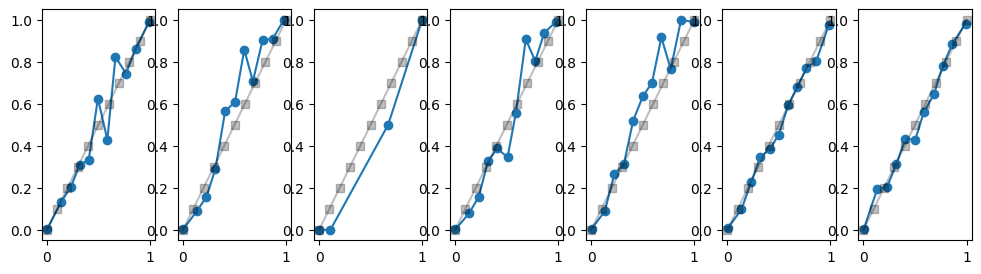

In [6]:
fig, ax = plt.subplots(1,K,figsize=(12,3))
colors = ["green","blue", "purple"]
n_bins = 1000
vbins = 10  
bins = np.linspace(0, 1, n_bins + 1)
v_bins = np.linspace(0, 1, vbins + 1)
clf.fit(X_train, y_train)    
for k in range(K):
    y_pred = clf.predict_proba(X_test)[:,k]
    y_binary = (y_test == k).astype(int)
    acc, conf = calibration_curve(y_binary, y_pred, n_bins=vbins+1)
    ax[k].plot(conf, acc, marker="o")
    ax[k].plot(v_bins, v_bins, marker="s", color="black", alpha=0.25 )

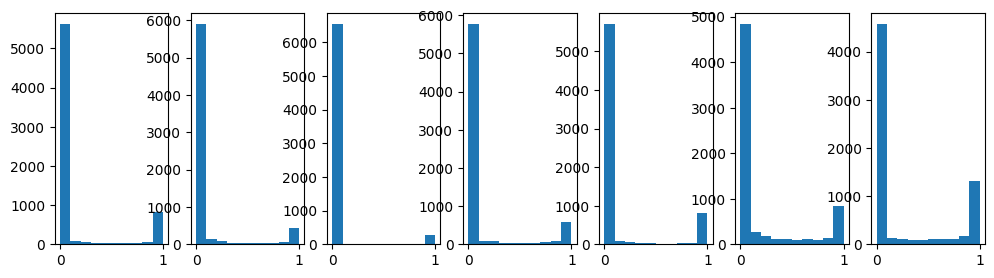

In [7]:
fig, ax = plt.subplots(1,K,figsize=(12,3))
pred = clf.predict_proba(X_test)
for k in range(K):
    y_pred = pred[:,k]
    ax[k].hist(y_pred)

In [8]:
collect = []

Y_train_pred = clf.predict_proba(X_train)
Y_test_pred = clf.predict_proba(X_test)


for k in range(K):

    num_k = (y_train == k).sum() 
    Xk_train, yk_train = Y_train_pred[y_train == k], np.ones(num_k)
    Xnotk_train, ynotk_train = Y_train_pred[y_train != k][:num_k], np.zeros(num_k)

    Xk_train = np.vstack([Xk_train, Xnotk_train])
    Yk_train = np.hstack([yk_train, ynotk_train])   
    
    binaryCLF = RandomForestClassifier()
    binaryCLF.fit(Xk_train, Yk_train)
    class_k = binaryCLF.predict(Y_test_pred).astype(int)

    yk_true = (y_test == k).astype(int)
    print(accuracy_score(yk_true , class_k))



    
    yk_pred = Y_test_pred[:, k]
    bin_pred = snap(yk_pred, bins=bins).reshape(-1, 1)


    transported = bin_pred.copy()
        
    for kk in range(2):
        k_plan = getTransortPlanK(scores=bin_pred, y=class_k, k=kk, bins=bins)
        if k_plan is not None:
            transported = applyTransportPlan(a=transported, M=k_plan, y=class_k, k=kk, bins=bins)
    

    collect.append(transported)
    


collected = np.hstack(collect)
collected = np.divide(collected, collected.sum(axis=1).reshape(-1,1))



print("wasscal: %f" % ECE(labels = y_test, probs=collected))

0.9836884643644379
0.9842762674504041
0.9998530492285085
0.9848640705363703
0.9860396767083027
0.9469507714915504
0.9557678177810434
wasscal: 2.062704


In [9]:

X_train_logits, X_test_logits, y_train_logits, y_test_logits = train_test_split(
    np.log(clf.predict_proba(X_test) + 1e-12).astype(np.float32),
    y_test,
    shuffle=False,
    test_size=int(y_test.shape[0]/2),
)

print("uncal: %f" % ECE(labels = y_test_logits, probs=np.exp(X_test_logits)))


calibrator = CalibrationLayer(method="Temperature", logits=X_train_logits, labels=y_train_logits)
ts = calibrator.calibrate().evaluate(X_test_logits)


print("ts: %f" % ECE(labels= y_test_logits, probs=ts))

calibrator2 = CalibrationLayer(method="Vector", logits=X_train_logits, labels=y_train_logits, K=K)
vs = calibrator2.calibrate().evaluate(X_test_logits)
print("vs: %f" % ECE(labels= y_test_logits, probs=vs))


calibrator3 = CalibrationLayer(method="Matrix", logits=X_train_logits, labels=y_train_logits, K=K)
ms = calibrator3.calibrate(ODIR=True, L2=True).evaluate(X_test_logits)
print("ms: %f" % ECE(labels= y_test_logits, probs=ms))


uncal: 3.098475
ts: 3.485737
vs: 3.627136
ms: 68.677177
